## Proyecto 1 - Modelo anterior

Juan Camilo Bello - 201820698

Nicolas Ricaurte - 201621525

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [33]:
# Cargamos los datos del archivo CSV
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"], na_values='?')

#ver si cada columna tiene caracteres no numericos
df.apply(lambda x: sum(x.apply(type) == str), axis=0)
#Pasar todos los valores a numericos
df = df.apply(pd.to_numeric, errors='coerce')
#Eliminar las filas con valores nulos
df = df.dropna()
#Arreglar la columna num
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

### Desarrollo Modelo Bayesiano

In [34]:
# Importamos las bibliotecas necesarias
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import pandas as pd

# Creamos el modelo bayesiano
model = BayesianNetwork([('age', 'chol'), ('age', 'fbs'), ('age', 'trestbps'), ('sex', 'chol'),
                        ('sex', 'fbs'), ('sex', 'trestbps'), ('chol', 'num'), ('fbs', 'num'), ('trestbps', 'num'), 
                        ('num','exang'), ('num','cp')])

# Estimamos las distribuciones de probabilidad usando MLE
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Estimamos las distribuciones de probabilidad usando MLE y BayesianEstimator
model.fit(df, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

# Hacemos inferencias en el modelo bayesiano
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

# Ejemplo de inferencia para un paciente de 60 años, hombre, con dolor torácico tipo 2, presión arterial en reposo de 145, colesterol de 233, sin ayuno de azúcar en sangre,
# electrocardiograma en reposo normal, frecuencia cardíaca máxima alcanzada durante el ejercicio de 142, sin angina inducida por ejercicio, depresión del segmento ST de 2.4,
# pendiente del segmento ST de plano, 1 vaso sanguíneo coloreado por flourosopía y una Thal de 3
q = infer.query(['num'], evidence={'age': 29, 'sex': 1, 'cp': 1, 'trestbps': 100, 'chol': 200,'exang': 1,'fbs': 1})
print(q)


+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.3405 |
+--------+------------+
| num(1) |     0.6595 |
+--------+------------+


### Gráfica del modelo 

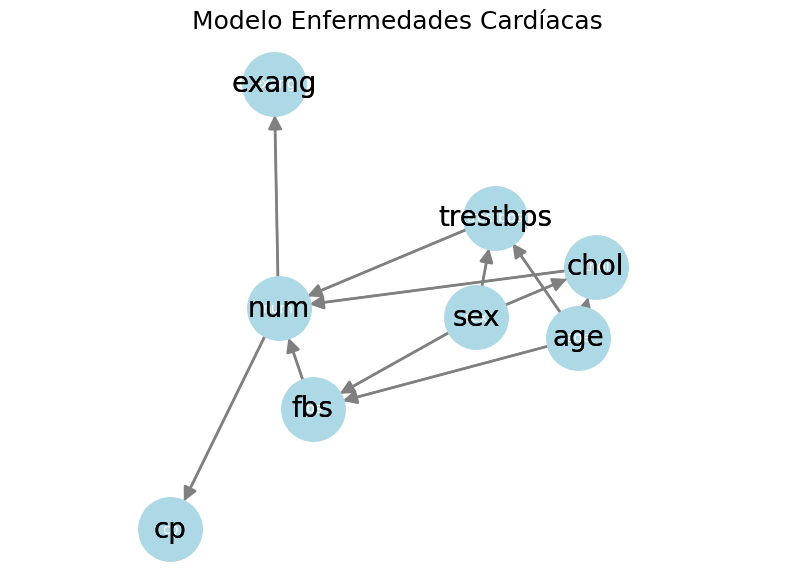

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Definición del DAG
nodes = ['age', 'chol', 'fbs', 'trestbps', 'sex', 'num', 'cp', 'exang']
edges = [('age', 'chol'), ('age', 'fbs'), ('age', 'trestbps'), ('sex', 'chol'),
                        ('sex', 'fbs'), ('sex', 'trestbps'), ('chol', 'num'), ('fbs', 'num'), ('trestbps', 'num'), 
                        ('num','exang'), ('num','cp')]

# Creación del grafo
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Configuración del estilo de visualización
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5, seed=483902)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='green', edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10, font_color='white')
nx.draw_networkx_edges(G, pos, arrowsize=20, edge_color='gray', width=1.5, arrowstyle='->')

# Dibujar el grafo
nx.draw_networkx(G, pos, node_size=2000, node_color='lightblue', font_size=20, arrowsize=20, width=2, linewidths=2, edge_color='grey')

# Dibujar las etiquetas de los nodos
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

# Establecer límites de zoom

plt.xlim(-0.7, 0.7)

# Mostrar la visualización del DAG
plt.title("Modelo Enfermedades Cardíacas", fontsize=18)
plt.axis('off')
plt.show()


# Proyecto 2 - Predicción de Enfermedades Cardíacas

Juan Camilo Bello - 201820698

Nicolas Ricaurte - 201621525

### Desempeño del modelo bayesiano con los datos de entrenamiento

In [1]:
# Importamos las bibliotecas necesarias
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import pandas as pd
import numpy as np

# Cargamos los datos del archivo CSV
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"], na_values='?')

#ver si cada columna tiene caracteres no numericos
df.apply(lambda x: sum(x.apply(type) == str), axis=0)
#Pasar todos los valores a numericos
df = df.apply(pd.to_numeric, errors='coerce')
#Eliminar las filas con valores nulos
df = df.dropna()

# convertimos las columnas con valores continuos en 10 rangos
df['age'] = pd.cut(df['age'], 10, labels = np.arange(10))
df['trestbps'] = pd.cut(df['trestbps'], 10, labels = np.arange(10))
df['chol'] = pd.cut(df['chol'], 10, labels = np.arange(10))
df['thalach'] = pd.cut(df['thalach'], 10, labels = np.arange(10))
df['oldpeak'] = pd.cut(df['oldpeak'], 10, labels = np.arange(10))

# Dividir el dataframe en dos conjuntos de datos: entrenamiento y prueba
from sklearn.model_selection import train_test_split
train_og, test_og = train_test_split(df, test_size=0.3)

In [2]:
# Identificar los valores faltantes en el train_og set
missing_values = {}
for column in train_og.columns:
    train_values = set(train_og[column].unique())
    test_values = set(test_og[column].unique())
    missing_values[column] = test_values - train_values

# Agregar filas al train_og set para cualquier valor faltante
for i, row in test_og.iterrows():
    if any(row[column] in missing_values[column] for column in missing_values):
        train_og = train_og.append(row)
        test_og = test_og.drop(i)

/var/folders/m6/xx2tl5h91wbf651lwjmb3f900000gn/T/ipykernel_46390/700938989.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_og = train_og.append(row)
/var/folders/m6/xx2tl5h91wbf651lwjmb3f900000gn/T/ipykernel_46390/700938989.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_og = train_og.append(row)
/var/folders/m6/xx2tl5h91wbf651lwjmb3f900000gn/T/ipykernel_46390/700938989.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_og = train_og.append(row)


In [3]:
import numpy as np

# Eliminamos filas con valores faltantes
train = train_og.dropna()
test = test_og.dropna()

# Solo nos quedamos con las columnas que nos interesan age, sex, cp, trestbps, chol, fbs, exang, num
train = train.drop(columns=['restecg', 'thalach', 'oldpeak', 'slope', 'ca', 'thal'], axis=1)
test = test.drop(columns=['restecg', 'thalach', 'oldpeak', 'slope', 'ca', 'thal'], axis=1)

# Convertimos la columna de diagnóstico en un valor binario
train['num'] = train['num'].apply(lambda x: 0 if x == 0 else 1)
test['num'] = test['num'].apply(lambda x: 0 if x == 0 else 1)

In [4]:
# Creamos el modelo bayesiano
model = BayesianNetwork([('age', 'chol'), ('age', 'fbs'), ('age', 'trestbps'), ('sex', 'chol'),
                        ('sex', 'fbs'), ('sex', 'trestbps'), ('chol', 'num'), ('fbs', 'num'), ('trestbps', 'num'), 
                        ('num','exang'), ('num','cp')])

# Estimamos las distribuciones de probabilidad usando MLE
model.fit(train, estimator=MaximumLikelihoodEstimator)

# Estimamos las distribuciones de probabilidad usando MLE y BayesianEstimator
model.fit(train, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

# Hacemos inferencias en el modelo bayesiano
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

In [5]:
# Hacer predicciones sobre los datos de prueba
predictions = []
for i in range(len(test)):

    evidence = {'age': test.iloc[i][0], 'sex': test.iloc[i][1], 'cp': test.iloc[i][2], 'trestbps': test.iloc[i][3], 'chol': test.iloc[i][4],'exang': test.iloc[i][5],'fbs': test.iloc[i][6]}
    prediction = infer.query(['num'], evidence=evidence)
    predictions.append(prediction)

# Convertir las predicciones a valores binarios
predictions_binary = [1 if prediction.values[1] > 0.5 else 0 for prediction in predictions]

# Convertir las etiquetas a una lista
labels = test['num'].tolist()

# Crear la matriz de confusión
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(labels, predictions_binary)

# tn: true negative, fp: false positive, fn: false negative, tp: true positive

# Calcular los porcentajes de verdaderos y falsos positivos y negativos
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / sum(cm.ravel())
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)

Accuracy: 0.735632183908046
Precision: 0.7209302325581395
Recall: 0.7380952380952381
Specificity: 0.7333333333333333


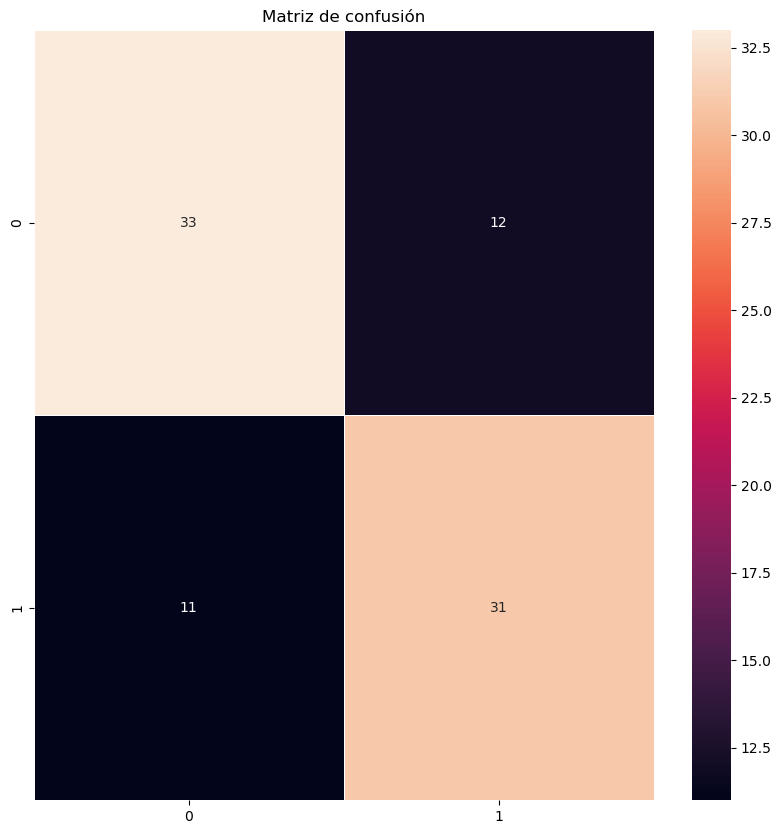

In [6]:
# mostrar la matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot=True, linewidths=0.5, fmt= '.0f',ax=ax)
plt.title("Matriz de confusión")
plt.show()


In [7]:
from pgmpy.estimators import K2Score
scoring_method = K2Score(data=df)
# Un valor menor en el puntaje K2 indica un mejor ajuste del modelo a los datos
print(scoring_method.score(model))

-3069.78383668792


### Nuevo Modelo Bayesiano Hill Climbing

In [8]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score

scoring_method = K2Score(data=df)
esth = HillClimbSearch(data=df)
new_model = esth.estimate(
    scoring_method=scoring_method,
    max_indegree=1,
    max_iter=int(1e6),
    black_list=(
        tuple(['age', 'sex']),
        tuple(['cp', 'sex']),
        tuple(['trestbps', 'sex']),
        tuple(['chol', 'sex']),
        tuple(['fbs', 'sex']),
        tuple(['restecg', 'sex']),
        tuple(['thalach', 'sex']),
        tuple(['exang', 'sex']),
        tuple(['oldpeak', 'sex']),
        tuple(['slope', 'sex']),
        tuple(['ca', 'sex']),
        tuple(['thal', 'sex']),
        tuple(['num', 'sex']),
        tuple(['sex', 'age']),
        tuple(['cp', 'age']),
        tuple(['trestbps', 'age']),
        tuple(['chol', 'age']),
        tuple(['fbs', 'age']),
        tuple(['restecg', 'age']),
        tuple(['thalach', 'age']),
        tuple(['exang', 'age']),
        tuple(['oldpeak', 'age']),
        tuple(['slope', 'age']),
        tuple(['ca', 'age']),
        tuple(['thal', 'age']),
        tuple(['num', 'age'])
    )
)

print(new_model)
print(new_model.nodes())
print(new_model.edges())

from pgmpy.estimators import K2Score
scoring_method = K2Score(data=df)
# Un valor menor en el puntaje K2 indica un mejor ajuste del modelo a los datos
print(scoring_method.score(new_model))

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 14 nodes and 8 edges
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
[('sex', 'thal'), ('cp', 'exang'), ('oldpeak', 'slope'), ('slope', 'thalach'), ('thal', 'num'), ('num', 'ca'), ('num', 'cp'), ('num', 'oldpeak')]
-4900.506455691654


In [14]:
# encontrar el mejor modelo que tenga el mejor score de K2
best_model = None
best_score = float('inf')
black_list = (
        tuple(['age', 'sex']),
        tuple(['cp', 'sex']),
        tuple(['trestbps', 'sex']),
        tuple(['chol', 'sex']),
        tuple(['fbs', 'sex']),
        tuple(['restecg', 'sex']),
        tuple(['thalach', 'sex']),
        tuple(['exang', 'sex']),
        tuple(['oldpeak', 'sex']),
        tuple(['slope', 'sex']),
        tuple(['ca', 'sex']),
        tuple(['thal', 'sex']),
        tuple(['num', 'sex']),
        tuple(['sex', 'age']),
        tuple(['cp', 'age']),
        tuple(['trestbps', 'age']),
        tuple(['chol', 'age']),
        tuple(['fbs', 'age']),
        tuple(['restecg', 'age']),
        tuple(['thalach', 'age']),
        tuple(['exang', 'age']),
        tuple(['oldpeak', 'age']),
        tuple(['slope', 'age']),
        tuple(['ca', 'age']),
        tuple(['thal', 'age']),
        tuple(['num', 'age'])
    )

for i in range(1, 13):
    new_model = esth.estimate(
    scoring_method=scoring_method,
    max_indegree=i,
    max_iter=int(1e10),
    black_list=black_list

)
    score = scoring_method.score(new_model)
    if score < best_score:
        best_model = new_model
        max_indegree = i
        best_score = score

print(best_model)
print(max_indegree)
print(best_score)
print(best_model.nodes())
print(best_model.edges())

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

  0%|          | 0/10000000000 [00:00<?, ?it/s]

DAG with 14 nodes and 8 edges
1
-4900.506455691654
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
[('sex', 'thal'), ('cp', 'exang'), ('oldpeak', 'slope'), ('slope', 'thalach'), ('thal', 'num'), ('num', 'ca'), ('num', 'cp'), ('num', 'oldpeak')]


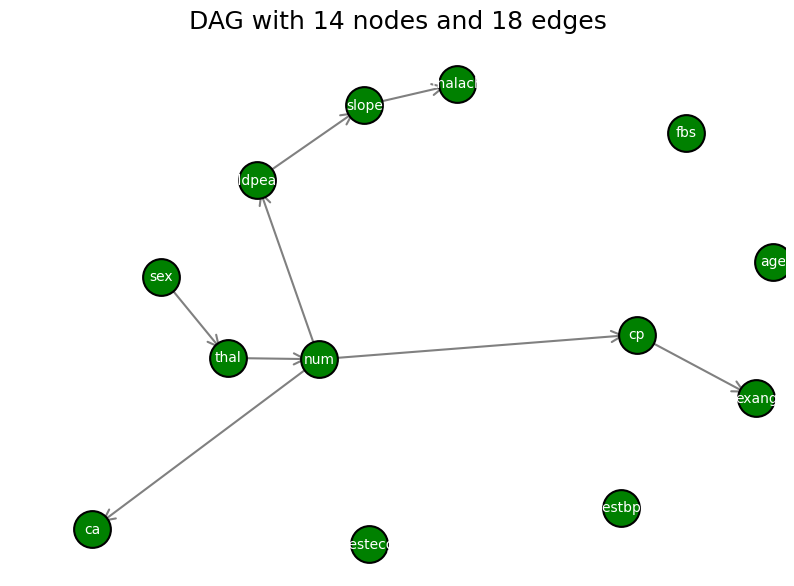

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Definición del DAG
nodes = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
edges = [('sex', 'thal'), ('cp', 'exang'), ('oldpeak', 'slope'), ('slope', 'thalach'), ('thal', 'num'), ('num', 'ca'), ('num', 'cp'), ('num', 'oldpeak')]


# Creación del grafo
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Configuración del estilo de visualización
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5, seed=7986)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='green', edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10, font_color='white')
nx.draw_networkx_edges(G, pos, arrowsize=20, edge_color='gray', width=1.5, arrowstyle='->')

# Establecer límites de zoom

plt.xlim(-0.7, 0.7)

# Mostrar la visualización del DAG
plt.title("DAG with 14 nodes and 18 edges", fontsize=18)
plt.axis('off')
plt.show()

### Desempeño del modelo bayesiano con los datos de entrenamiento

In [10]:
import numpy as np

# Eliminamos filas con valores faltantes
train2 = train_og.dropna()
test2 = test_og.dropna()

# Solo nos quedamos con las columnas que nos interesan
train2 = train2.drop(columns=['restecg', 'age', 'trestbps', 'chol', 'fbs'], axis=1)
test2 = test2.drop(columns=['restecg', 'age', 'trestbps', 'chol', 'fbs' ], axis=1)

# Convertimos la columna de diagnóstico en un valor binario
train2['num'] = train2['num'].apply(lambda x: 0 if x == 0 else 1)
test2['num'] = test2['num'].apply(lambda x: 0 if x == 0 else 1)

In [11]:
# Creamos el modelo bayesiano
modelHill = BayesianNetwork([('sex', 'thal'), ('cp', 'exang'), ('oldpeak', 'slope'), ('slope', 'thalach'), ('thal', 'num'), ('num', 'ca'), ('num', 'cp'), ('num', 'oldpeak')])

# Estimamos las distribuciones de probabilidad usando MLE
modelHill.fit(train2, estimator=MaximumLikelihoodEstimator)

# Estimamos las distribuciones de probabilidad usando MLE y BayesianEstimator
modelHill.fit(train2, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

# Hacemos inferencias en el modelo bayesiano
from pgmpy.inference import VariableElimination

infer2 = VariableElimination(modelHill)

# Hacer predicciones sobre los datos de prueba
predictions2 = []
for i in range(len(test2)):

    evidence = {'sex': test2.iloc[i][0], 'cp': test2.iloc[i][1], 'thalach': test2.iloc[i][2],'exang': test2.iloc[i][3],'oldpeak': test2.iloc[i][4], 'slope': test2.iloc[i][5], 'ca': test2.iloc[i][6], 'thal': test2.iloc[i][7]}
    prediction = infer2.query(['num'], evidence=evidence)
    predictions2.append(prediction)

# Convertir las predicciones a valores binarios
predictions_binary = [1 if prediction.values[1] > 0.5 else 0 for prediction in predictions2]

# Convertir las etiquetas a una lista
labels = test2['num'].tolist()

# Crear la matriz de confusión
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(labels, predictions_binary)

# tn: true negative, fp: false positive, fn: false negative, tp: true positive

# Calcular los porcentajes de verdaderos y falsos positivos y negativos
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / sum(cm.ravel())
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)

Accuracy: 0.8045977011494253
Precision: 0.8048780487804879
Recall: 0.7857142857142857
Specificity: 0.8222222222222222


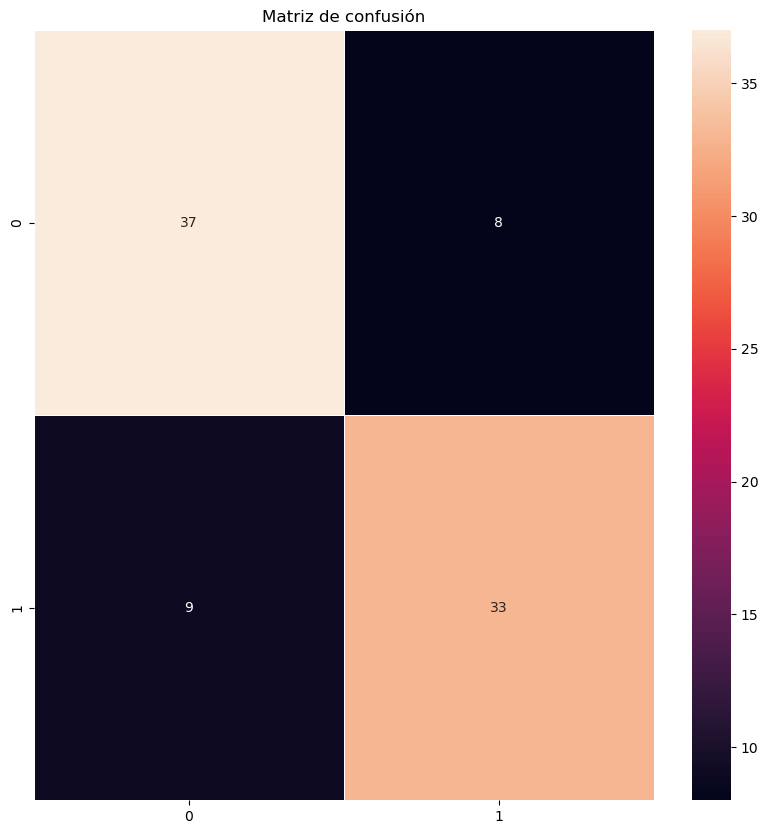

In [12]:
# mostrar la matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot=True, linewidths=0.5, fmt= '.0f',ax=ax)
plt.title("Matriz de confusión")
plt.show()

### Nuevo Modelo Bayesiano - Categorización alternativa

In [13]:
df_pc = pd.read_csv(url, names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"], na_values='?')

#ver si cada columna tiene caracteres no numericos
df_pc.apply(lambda x: sum(x.apply(type) == str), axis=0)
#Pasar todos los valores a numericos
df_pc = df_pc.apply(pd.to_numeric, errors='coerce')
#Eliminar las filas con valores nulos
df_pc = df_pc.dropna()
# Eliminar columnas que no nos interesan
df_pc = df_pc.drop(columns=['age', 'sex'], axis=1)

"""# Si la edad es mayor a 50, entonces es 1, sino es 0
df_pc['age'] = df_pc['age'].apply(lambda x: 1 if x > 50 else 0)"""

# Si cp es 1, 2 o 3, entonces es 1, sino es 0
df_pc['cp'] = df_pc['cp'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Si tresbps es mayor a 120, entonces es 1, sino es 0
df_pc['trestbps'] = df_pc['trestbps'].apply(lambda x: 1 if x > 120 else 0)

# Si chol es mayor a 200, entonces es 1, sino es 0
df_pc['chol'] = df_pc['chol'].apply(lambda x: 1 if x > 200 else 0)

# Si restecg es 1 o 2, entonces es 1, sino es 0
df_pc['restecg'] = df_pc['restecg'].apply(lambda x: 1 if x in [1, 2] else 0)

# Si thalach es mayor a 150, entonces es 1, sino es 0
df_pc['thalach'] = df_pc['thalach'].apply(lambda x: 1 if x > 150 else 0)

# Si oldpeak es mayor a 1, entonces es 1, sino es 0
df_pc['oldpeak'] = df_pc['oldpeak'].apply(lambda x: 1 if x > 1 else 0)

# Si slope es 1, entonces es 0, sino es 1
df_pc['slope'] = df_pc['slope'].apply(lambda x: 0 if x == 1 else 1)

# Si ca es 0, entonces es 0, sino es 1
df_pc['ca'] = df_pc['ca'].apply(lambda x: 0 if x == 0 else 1)

# Si thal es 3, entonces es 0, sino es 1
df_pc['thal'] = df_pc['thal'].apply(lambda x: 0 if x == 3 else 1)

# Si num es 0, entonces es 0, sino es 1
df_pc['num'] = df_pc['num'].apply(lambda x: 0 if x == 0 else 1)

In [14]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score

scoring_method = K2Score(data=df_pc)
esth = HillClimbSearch(data=df_pc)
new_model2 = esth.estimate(
    scoring_method=scoring_method,
    max_indegree=4,
    max_iter=int(1e6),
    black_list=(
        tuple(['age', 'sex']),
        tuple(['cp', 'sex']),
        tuple(['trestbps', 'sex']),
        tuple(['chol', 'sex']),
        tuple(['fbs', 'sex']),
        tuple(['restecg', 'sex']),
        tuple(['thalach', 'sex']),
        tuple(['exang', 'sex']),
        tuple(['oldpeak', 'sex']),
        tuple(['slope', 'sex']),
        tuple(['ca', 'sex']),
        tuple(['thal', 'sex']),
        tuple(['num', 'sex']),
        tuple(['sex', 'age']),
        tuple(['cp', 'age']),
        tuple(['trestbps', 'age']),
        tuple(['chol', 'age']),
        tuple(['fbs', 'age']),
        tuple(['restecg', 'age']),
        tuple(['thalach', 'age']),
        tuple(['exang', 'age']),
        tuple(['oldpeak', 'age']),
        tuple(['slope', 'age']),
        tuple(['ca', 'age']),
        tuple(['thal', 'age']),
        tuple(['num', 'age'])
    )
)

print(new_model2)
print(new_model2.nodes())
print(new_model2.edges())

from pgmpy.estimators import K2Score
scoring_method = K2Score(data=df)
# Un valor menor en el puntaje K2 indica un mejor ajuste del modelo a los datos
print(scoring_method.score(new_model2))

  0%|          | 0/1000000 [00:00<?, ?it/s]

DAG with 12 nodes and 16 edges
['cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
[('trestbps', 'fbs'), ('restecg', 'trestbps'), ('thalach', 'thal'), ('thalach', 'exang'), ('thalach', 'num'), ('exang', 'cp'), ('oldpeak', 'slope'), ('oldpeak', 'thal'), ('oldpeak', 'thalach'), ('slope', 'thalach'), ('slope', 'num'), ('thal', 'num'), ('num', 'cp'), ('num', 'ca'), ('num', 'exang'), ('num', 'restecg')]
-4215.460635099719


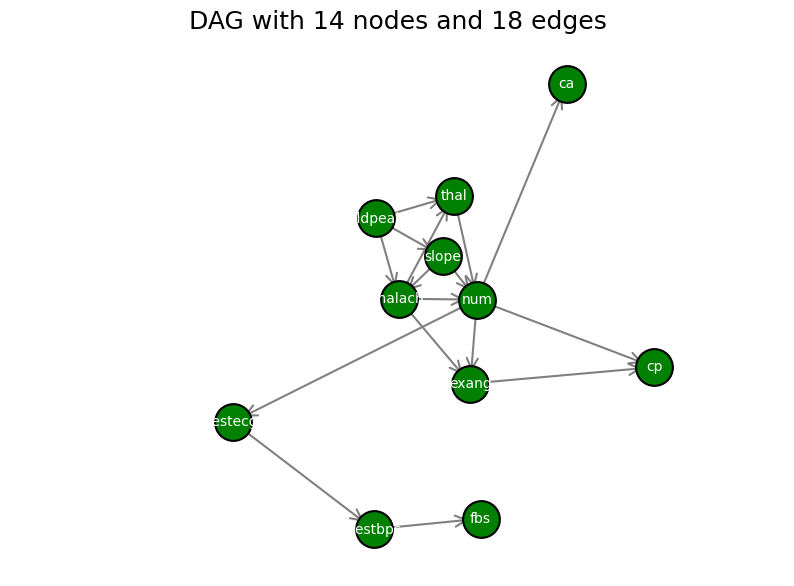

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Definición del DAG
nodes = ['cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
edges = [('trestbps', 'fbs'), ('restecg', 'trestbps'), ('thalach', 'thal'), ('thalach', 'exang'), ('thalach', 'num'), ('exang', 'cp'), ('oldpeak', 'slope'), ('oldpeak', 'thal'), ('oldpeak', 'thalach'), ('slope', 'thalach'), ('slope', 'num'), ('thal', 'num'), ('num', 'cp'), ('num', 'ca'), ('num', 'exang'), ('num', 'restecg')]

# Creación del grafo
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Configuración del estilo de visualización
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5, seed=543)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='green', edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10, font_color='white')
nx.draw_networkx_edges(G, pos, arrowsize=20, edge_color='gray', width=1.5, arrowstyle='->')

# Establecer límites de zoom

plt.xlim(-0.7, 0.7)

# Mostrar la visualización del DAG
plt.title("DAG with 14 nodes and 18 edges", fontsize=18)
plt.axis('off')
plt.show()

In [16]:
import numpy as np

# Eliminamos filas con valores faltantes
train3 = train_og.dropna()
test3 = test_og.dropna()

# Solo nos quedamos con las columnas que nos interesan
train3 = train3.drop(columns=['sex', 'age','chol'], axis=1)
test3 = test3.drop(columns=['sex', 'age','chol'], axis=1)


# Convertimos la columna de diagnóstico en un valor binario
train3['num'] = train3['num'].apply(lambda x: 0 if x == 0 else 1)
test3['num'] = test3['num'].apply(lambda x: 0 if x == 0 else 1)

In [17]:
# Creamos el modelo bayesiano
modelHill2 = BayesianNetwork([('trestbps', 'fbs'), ('restecg', 'trestbps'), ('thalach', 'thal'), ('thalach', 'exang'), 
                              ('thalach', 'num'), ('exang', 'cp'), ('oldpeak', 'slope'), ('oldpeak', 'thal'), ('oldpeak', 'thalach'), 
                              ('slope', 'thalach'), ('slope', 'num'), ('thal', 'num'), ('num', 'cp'), ('num', 'ca'), ('num', 'exang'), ('num', 'restecg')]
)

# Estimamos las distribuciones de probabilidad usando MLE
modelHill2.fit(train3, estimator=MaximumLikelihoodEstimator)

# Estimamos las distribuciones de probabilidad usando MLE y BayesianEstimator
modelHill2.fit(train3, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

# Hacemos inferencias en el modelo bayesiano
from pgmpy.inference import VariableElimination

infer3 = VariableElimination(modelHill2)

# Hacer predicciones sobre los datos de prueba
predictions3 = []
for i in range(len(test3)):

    evidence = {'cp': test3.iloc[i][0], 'trestbps': test3.iloc[i][1], 'fbs': test3.iloc[i][2],'restecg': test3.iloc[i][3],'thalach': test3.iloc[i][4], 'exang': test3.iloc[i][5], 'oldpeak': test3.iloc[i][6], 'slope': test3.iloc[i][7], 'ca': test3.iloc[i][8], 'thal': test3.iloc[i][9]}
    prediction = infer3.query(['num'], evidence=evidence)
    predictions3.append(prediction)

# Convertir las predicciones a valores binarios
predictions_binary = [1 if prediction.values[1] > 0.5 else 0 for prediction in predictions3]

# Convertir las etiquetas a una lista
labels = test3['num'].tolist()

# Crear la matriz de confusión
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(labels, predictions_binary)

# tn: true negative, fp: false positive, fn: false negative, tp: true positive

# Calcular los porcentajes de verdaderos y falsos positivos y negativos
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / sum(cm.ravel())
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)

Accuracy: 0.7931034482758621
Precision: 0.7857142857142857
Recall: 0.7857142857142857
Specificity: 0.8


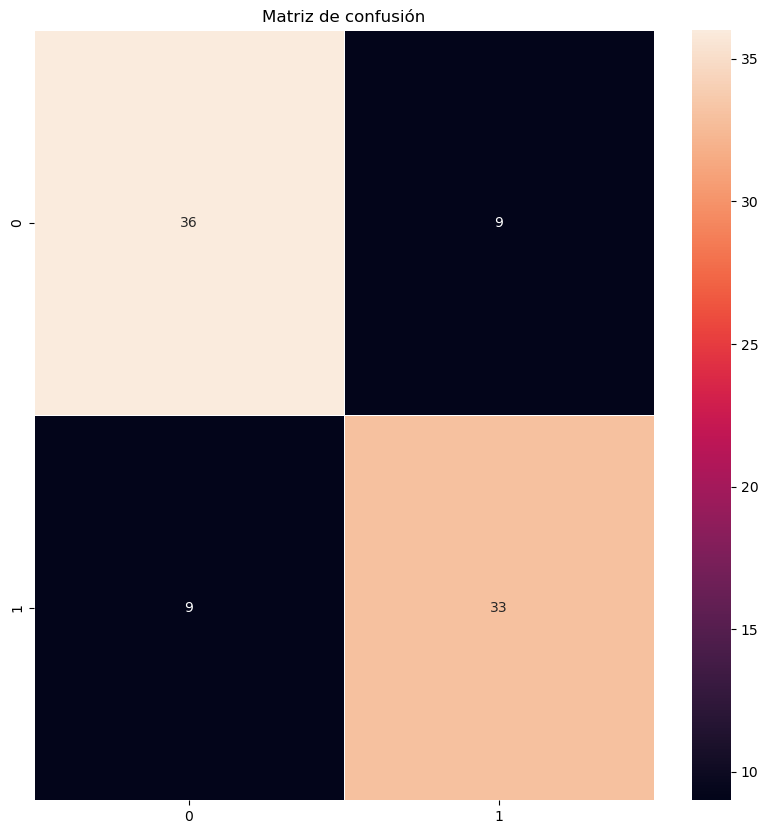

In [18]:
# mostrar la matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot=True, linewidths=0.5, fmt= '.0f',ax=ax)
plt.title("Matriz de confusión")
plt.show()